# Import Required Libraries

In [1]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

#  Load the Dataset

(60000, 784)
(10000, 784)


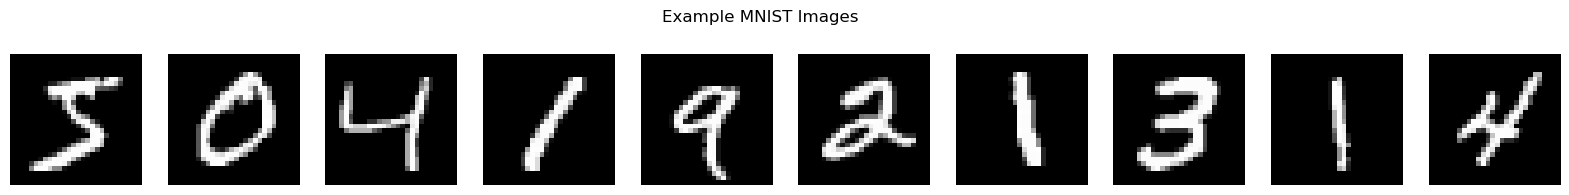

In [11]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()


# Define the input 
input_img = Input(shape=(784,))

# Load and preprocess the data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

# Display the first 10 images from the dataset
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Example MNIST Images')
plt.show()

# Define the Encoder

In [12]:
# Define the size of the encoded representation
encoding_dim = 32 

In [13]:
# Define the encoder layers
encoded = Dense(128, activation='relu')(input_img)
z_mean = Dense(encoding_dim)(encoded)
z_log_var = Dense(encoding_dim)(encoded)


In [14]:
# Reparameterization trick for sampling from latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], encoding_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

This sets up a dense layer with 128 units featuring a ReLU activation function, linked to the input_img. The subsequent lines establish two distinct dense layers, z_mean and z_log_var, each with encoding_dim units connected to the encoded layer. These layers are responsible for producing the mean and the logarithm of the variance of the latent distribution.

# Define the Decoder

In [15]:
# Define the decoder layers
decoder_input = Input(shape=(encoding_dim,))
decoded = Dense(128, activation='relu')(decoder_input)
decoded = Dense(784, activation='sigmoid')(decoded)

# Represent decoder model
decoder = Model(decoder_input, decoded)

# Reconstruct the image
output_img = decoder(z) # z is the latent representation

Two dense layers, one with a ReLU activation and the other with a sigmoid activation, are configured to restore the original input from its encoded form. A Keras model is then created, using decoder_input as the input and decoded as the output, to form the decoder network. This connection integrates the decoder network with the latent variable z, resulting in the reconstructed output image.

#  Define the VAE Model

In [16]:
# Define the VAE loss
reconstruction_loss = K.mean(K.binary_crossentropy(K.flatten(input_img), K.flatten(output_img)) * 784)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Define the VAE model
vae = Model(input_img, output_img)

In [17]:
# Compile the VAE
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 128)                  100480    ['input_5[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 32)                   4128      ['dense_5[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 32)                   4128      ['dense_5[0][0]']             
                                                                                            


This computes the reconstruction loss by assessing the variance between the input and output images. It calculates this by determining the mean binary cross-entropy across the flattened images, adjusted for the total number of input features, which is 784.
This function computes the Kullback-Leibler divergence, which quantifies the deviation of one probability distribution from another expected probability distribution. This divergence is utilized to regularize the latent space.
This measures the total loss for the variational autoencoder (VAE) model, which is the aggregate of the reconstruction loss and the KL divergence loss

# Train the model

In [20]:
# Train the VAE
history= vae.fit(x_train,
        epochs=20,
        batch_size=256,
        shuffle=True,
        validation_data=(x_test, None))

Epoch 1/20
235/235 [==============================] - 1s 4ms/step - loss: 110.4082 - val_loss: 109.2793
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 110.1448 - val_loss: 109.1285
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 109.9403 - val_loss: 109.1219
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 109.7842 - val_loss: 108.9994
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 109.6273 - val_loss: 108.8119
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 109.4685 - val_loss: 108.5007
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 109.2563 - val_loss: 108.3000
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 109.1299 - val_loss: 108.1175
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 109.0553 - val_loss: 108.0403
Epoch 10/20
235/235 [==============================] - 1s 4ms/st

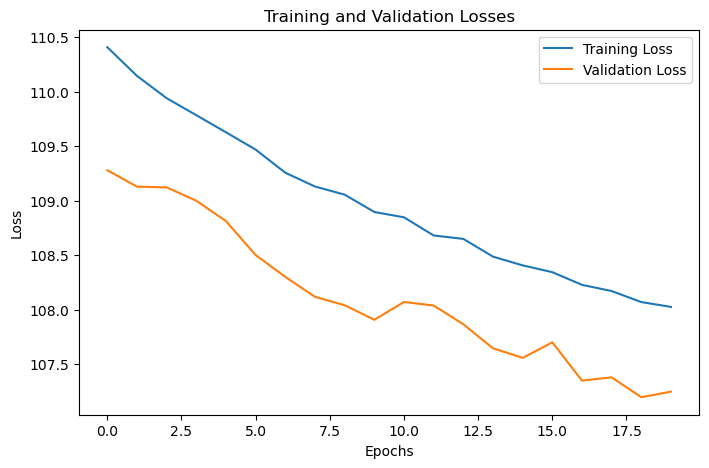

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Visualize the Results

313/313 [==============================] - 0s 414us/step


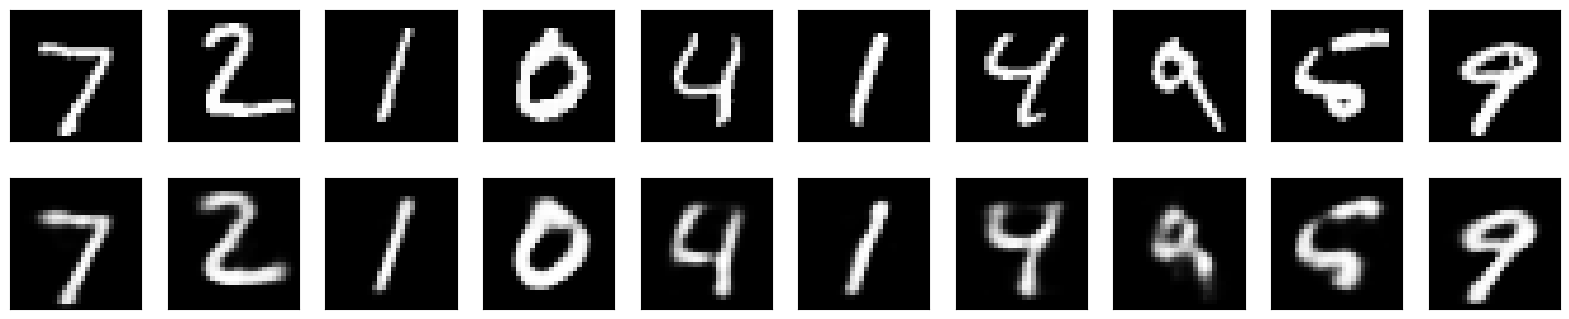

In [19]:
# Display original and reconstructed images
decoded_imgs = vae.predict(x_test)

n = 10  # digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

This script displays original MNIST dataset images next to their reconstructed counterparts from a trained VAE model. It loops through a predefined number of digits (n), placing each original and its reconstruction side by side within a subplot grid. The command plt.show() is then used to render the grid showing both the original and reconstructed images.